# 03. XÂY DỰNG VÀ TRAIN MÔ HÌNH LSTM BASELINE

Dự đoán giá Bitcoin – Đồ án tốt nghiệp  
Người thực hiện: doanhuy23

In [17]:
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q
# Hoặc CPU only: %pip install torch -q

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

In [18]:
# Load dataset
X_train = np.load("D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\X_train.npy")
X_val = np.load("D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\X_val.npy")
X_test = np.load("D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\X_test.npy")
y_train = np.load("D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\y_train.npy")
y_val = np.load("D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\y_val.npy")
y_test = np.load("D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\y_test.npy")
scaler = np.load("D:\Code\python\DoAn_LSTM_PredictPrice\processing\data\processed\scaler.npy", allow_pickle=True).item()

print(f"Train: {X_train.shape} → {y_train.shape}")
print(f"Val:   {X_val.shape}   → {y_val.shape}")
print(f"Test:  {X_test.shape}  → {y_test.shape}")

Train: (2242, 60, 1) → (2242,)
Val:   (480, 60, 1)   → (480,)
Test:  (481, 60, 1)  → (481,)


In [19]:
# Chuyển sang torch tensor
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val).reshape(-1, 1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

# DataLoader
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                          batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # lấy output cuối cùng
        return out

# Khởi tạo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Đang dùng: {device}")
print(model)

Đang dùng: cpu
LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


Epoch 10 | Train Loss: 0.000368 | Val Loss: 0.000501
Epoch 20 | Train Loss: 0.000266 | Val Loss: 0.000394
Epoch 30 | Train Loss: 0.000195 | Val Loss: 0.001189
Epoch 40 | Train Loss: 0.000171 | Val Loss: 0.000328
Epoch 50 | Train Loss: 0.000163 | Val Loss: 0.000270


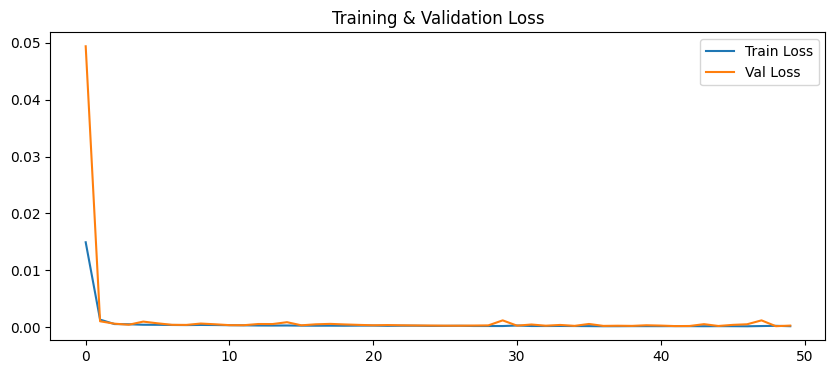

In [21]:
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    batch_losses = []
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val.to(device))
        val_loss = criterion(val_pred, y_val.to(device)).item()
    
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

# Vẽ loss
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [22]:
model.eval()
with torch.no_grad():
    test_pred_scaled = model(X_test.to(device)).cpu().numpy()
    y_test_scaled = y_test.numpy()

# Inverse scaling
test_pred = scaler.inverse_transform(test_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test_scaled)

print("5 dự đoán gần nhất (USD):")
for i in range(-5, 0):
    print(f"Thực tế: ${y_test_actual[i][0]:,.2f} | Dự đoán: ${test_pred[i][0]:,.2f}")

5 dự đoán gần nhất (USD):
Thực tế: $91,345.09 | Dự đoán: $83,808.98
Thực tế: $93,454.26 | Dự đoán: $83,713.37
Thực tế: $92,133.65 | Dự đoán: $84,832.87
Thực tế: $89,389.36 | Dự đoán: $85,664.95
Thực tế: $89,235.89 | Dự đoán: $85,298.45



KẾT QUẢ LSTM BASELINE (window=60)
RMSE : $8,494.13
MAE  : $7,499.02
MAPE : 7.46%


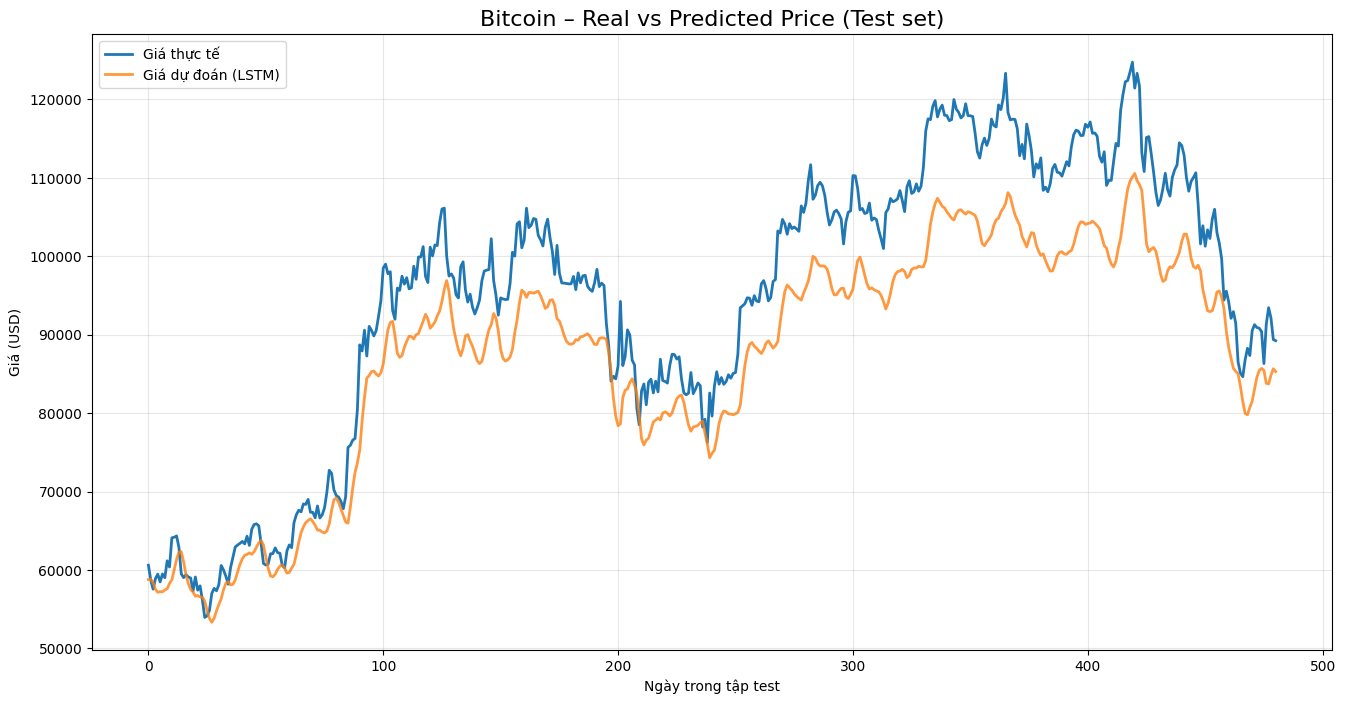

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred))
mae = mean_absolute_error(y_test_actual, test_pred)
mape = np.mean(np.abs((y_test_actual - test_pred) / y_test_actual)) * 100

print(f"\nKẾT QUẢ LSTM BASELINE (window=60)")
print(f"RMSE : ${rmse:,.2f}")
print(f"MAE  : ${mae:,.2f}")
print(f"MAPE : {mape:.2f}%")

# Vẽ đồ thị
plt.figure(figsize=(16,8))
plt.plot(y_test_actual, label='Giá thực tế', linewidth=2)
plt.plot(test_pred, label='Giá dự đoán (LSTM)', linewidth=2, alpha=0.8)
plt.title('Bitcoin – Real vs Predicted Price (Test set)', fontsize=16)
plt.xlabel('Ngày trong tập test')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/lstm_baseline_window60.pth")
print("ĐÃ LƯU MODEL: models/lstm_baseline_window60.pth")

ĐÃ LƯU MODEL: models/lstm_baseline_window60.pth
